# Word2vec

## How it works

Imagine I have two sentences:
- "Formula One driver Lewis Hamilton is a seven time world champion". 
- "Ferrari driver Sebastian Vettel fails to qualify for the fifth Grand Prix in a row"

Say I want find words that are semantically related to Lewis.

<!-- We can represent "Lewis" with [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0], where the first 11 words are from the first sentence, and the last 14 words are from the second sentence. -->

In word2vec we can use two different algorithms, continuous bag of words (CBOW) and skip-gram negative sampling. 

![image.png](../../images/w2v_1.png)

### Continuous bag of words (CBOW)

We take a window of n words surrounding "Lewis" and use those words as input into a neural network, using the logic that if certains words appear together often, then they're most likely semantically related. We take these surrounding words and plug them into a neural network to train weights which predict "Lewis".

We plug in a one hot vector for each word in the window and train the hidden layer to output probabilities of the current word ("Lewis"). Therefore the order of the words do not matter, just what the words are.

![image.png](../../images/w2v_2.png)

### Skip Gram Negative Sampling

Whereas, in the second option of using the continuous skip-gram architecture; the model uses the current word to predict the surrounding window of context words. The skip-gram architecture weighs nearby context words more heavily than more distant context words. The output probabilities are going to relate to how likely it is to find each vocabulary word near our input word. For example, if you gave the trained network the input word “Europe”, the output probabilities are going to be much higher for words like “Belgium” and “Continent” than for unrelated words like “fruits” and “cats”.


In [2]:
import os
import json
import pandas as pd
import numpy as np
import sys  
sys.path.insert(0, '..')
import std_func

df = pd.read_csv("../data/preprocessed.csv")

Here we split each document by word to create a word vector

In [ ]:
from gensim.models.word2vec import Word2Vec
from gensim import utils

revs_processed = df["coDescription_stopwords"].apply(lambda x: utils.simple_preprocess(x))
revs_processed.head()

0    [mongodb, leading, modern, general, purpose, d...
1    [salesforce, global, leader, customer, relatio...
2    [splunk, provides, innovative, software, solut...
3    [okta, leading, independent, provider, identit...
4    [veeva, leading, provider, industry, cloud, so...
Name: coDescription_stopwords, dtype: object

Now lets build the Word2Vec model

In [5]:
model_w = Word2Vec(revs_processed, vector_size=200)

We can examine words and see which words are most similar. Below are the most similar words to `cloud`, `trial`, and `oil`.

In [6]:
model_w.wv.most_similar(positive =['cloud'], topn = 5)

[('saas', 0.8176637887954712),
 ('server', 0.8041165471076965),
 ('web', 0.7686783671379089),
 ('splunk', 0.7515721321105957),
 ('architecture', 0.7492509484291077)]

In [7]:
model_w.wv.most_similar(positive =['trial'], topn = 5)

[('study', 0.8650659322738647),
 ('trials', 0.6853712797164917),
 ('clinicaltrial', 0.6389145255088806),
 ('trialin', 0.6141780018806458),
 ('randomized', 0.6040858626365662)]

In [8]:
model_w.wv.most_similar(positive =['oil'], topn = 5)

[('natural', 0.7331386208534241),
 ('flared', 0.6302977204322815),
 ('flaring', 0.6250402331352234),
 ('oiland', 0.6084830164909363),
 ('residue', 0.6022297143936157)]

Now we'll map these word vectors back to each document, by averaging all the word vectors that belong to words in a given document (filing)

In [10]:
def doc_to_vec(text):
    word_vecs = [model_w.wv[w] for w in text if w in model_w.wv]
    
    if len(word_vecs) == 0:
        return np.zeros(model_w.vector_size)
    
    return np.mean(word_vecs, axis = 0)

doc_vec = pd.DataFrame(revs_processed.apply(doc_to_vec).tolist())
labels = np.asarray(model_w.wv.index_to_key)

If you're interested, the entire 200 dimensions of each document is below:

In [12]:
doc_vec

0         1         2         3         4         5         6    \
0    0.230080 -0.126300 -0.002233 -0.118328  0.041198  0.072288 -0.260245   
1    0.242276 -0.125751 -0.042330 -0.208087  0.027872  0.094977 -0.221014   
2    0.278489 -0.187427 -0.019600 -0.227413  0.010551  0.096436 -0.277223   
3    0.311336 -0.179291 -0.032575 -0.192984  0.018396  0.091703 -0.286246   
4   -0.079829  0.126418  0.186824 -0.085248 -0.070656  0.040806 -0.083509   
..        ...       ...       ...       ...       ...       ...       ...   
670 -0.181553  0.138582  0.290301  0.150026 -0.168338  0.053430 -0.053903   
671  0.009346 -0.040671  0.156392 -0.027940  0.069960 -0.133396 -0.342145   
672 -0.201035  0.190768  0.346184 -0.022988 -0.108055  0.013555  0.068737   
673 -0.142128 -0.000711  0.209613  0.088078 -0.251125 -0.009731 -0.107100   
674  0.223753 -0.188008 -0.041582 -0.158960 -0.001938  0.125208 -0.164223   

          7         8         9    ...       190       191       192  \
0   -0.648401 -0.024348  0.004195  ... -0.089304 -0.081340  0.255366   
1   -0.620727 -0.013886 -0.022497  ... -0.113060 -0.086239  0.296429   
2   -0.543228  0.028471 -0.001014  ... -0.180955 -0.065628  0.247190   
3   -0.599842  0.018901  0.063998  ... -0.149842 -0.064881  0.275643   
4   -0.501400 -0.122064 -0.005213  ...  0.079878 -0.195840  0.094052   
..        ...       ...       ...  ...       ...       ...       ...   
670 -0.568511 -0.279689 -0.097499  ...  0.297532 -0.252027  0.167082   
671 -0.197312  0.175208  0.238380  ...  0.111864 -0.130621  0.037116   
672 -0.458800 -0.102390 -0.139662  ...  0.194089 -0.154398 -0.050350   
673 -0.459452 -0.193863 -0.102793  ...  0.208488 -0.327351 -0.017211   
674 -0.473048 -0.086926 -0.025703  ... -0.195866 -0.095400  0.190909   

          193       194       195       196       197       198       199  
0    0.365446  0.103208 -0.116193  0.154480 -0.236381 -0.179704  0.093691  
1    0.417858  0.100090 -0.133572  0.173904 -0.189703 -0.184756  0.103949  
2    0.355751  0.042588 -0.140992  0.219621 -0.235593 -0.177999  0.105229  
3    0.368003  0.106282 -0.130572  0.225259 -0.229642 -0.184946  0.167151  
4    0.405890  0.073693 -0.117397  0.091124 -0.112062 -0.106151  0.064966  
..        ...       ...       ...       ...       ...       ...       ...  
670  0.652590  0.067880 -0.059678  0.044047  0.067460 -0.157590  0.082995  
671  0.207656  0.149990  0.108676  0.162755 -0.360273 -0.033503 -0.009733  
672  0.392868  0.036941 -0.150806 -0.014858 -0.020565 -0.117548  0.202379  
673  0.590526  0.127214 -0.094867  0.014993 -0.095899 -0.160012  0.112940  
674  0.310807  0.145625 -0.170965  0.158072 -0.200957 -0.087190  0.181795  

[675 rows x 200 columns]

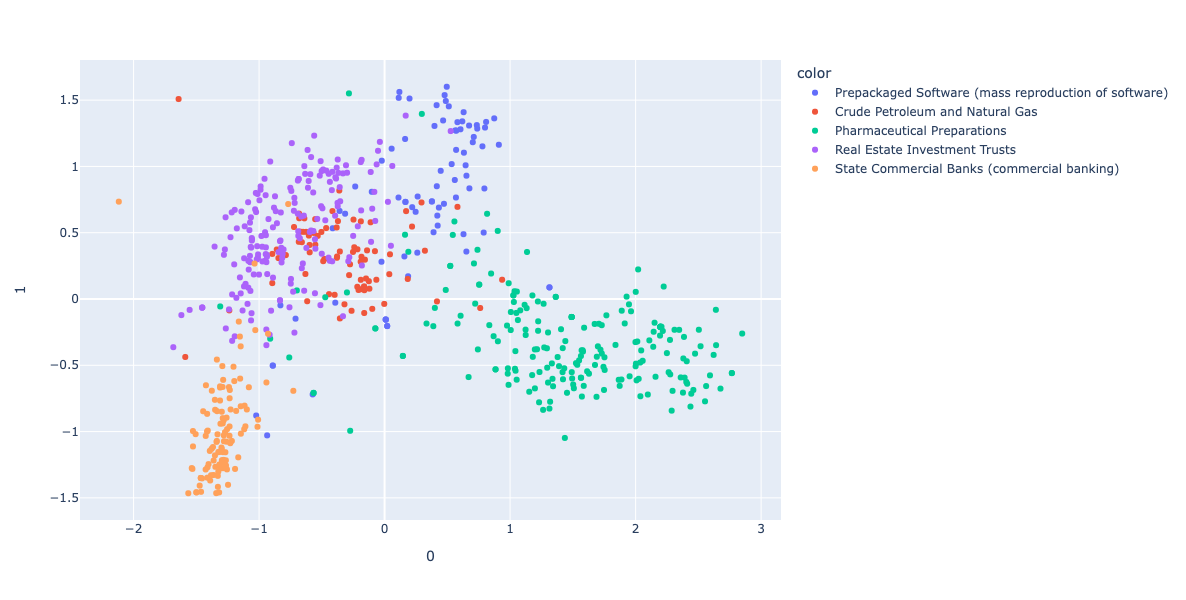

In [13]:
plot_pca = std_func.visualize_pca(doc_vec, df.loc[:,["name","SIC_desc"]])

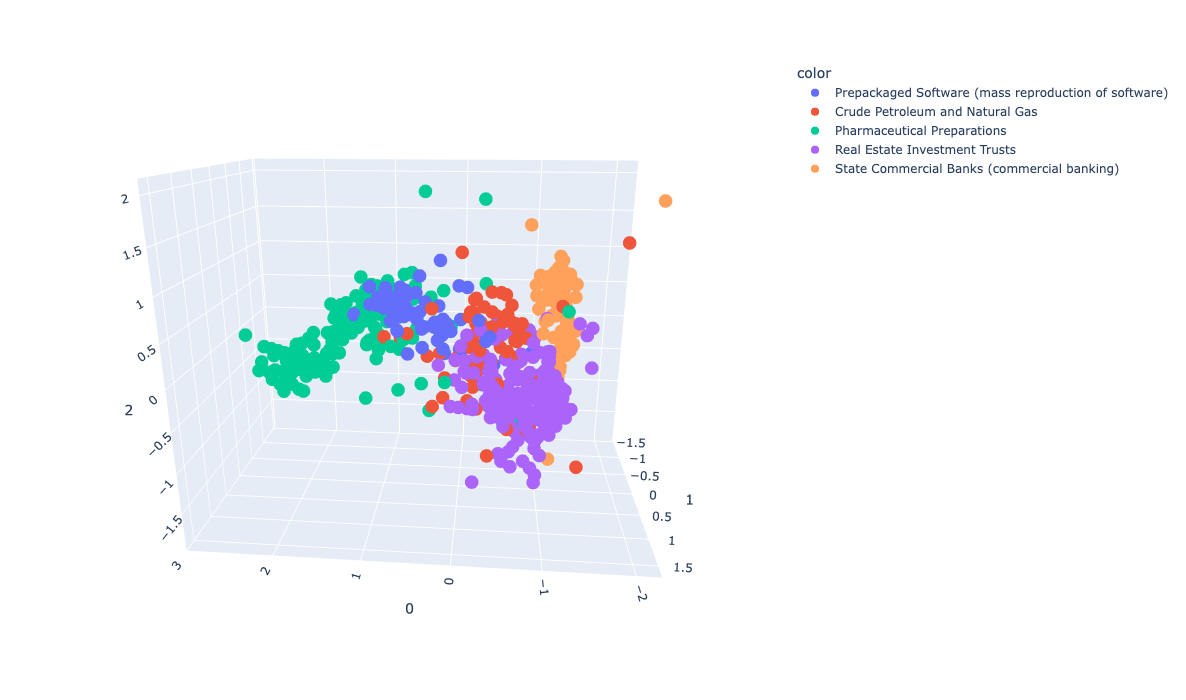

In [14]:
std_func.pca_visualize_3d(plot_pca)

In [28]:
from gensim.models import doc2vec
from collections import namedtuple

# Load data

# doc1 = ["This is a sentence", "This is another sentence"]

# Transform data (you can add more data preprocessing steps) 

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(df["coDescription"]):
    words = text.lower().split()
    tags = [i]
    docs.append(analyzedDocument(words, tags))

# Train model (set min_count = 1, if you want the model to work with the provided example data set)

model = doc2vec.Doc2Vec(docs, vector_size = 100, window = 10, min_count = 1, workers = 4)

In [38]:
# Get the vectors

doc_vec_2 = pd.DataFrame([model.dv[doc] for doc in np.arange(0,len(docs))])
doc_vec_2

0         1         2         3         4         5         6   \
0   -0.812571 -2.247206  3.160013 -0.752811  2.708562 -1.627653 -1.886912   
1   -1.616209 -0.789537  1.187985  0.018414  2.783114  0.465835  0.028536   
2   -1.437201 -1.478694  1.853095 -0.876434  4.814758  1.226785 -0.419795   
3   -0.971561 -1.586059  0.019064 -0.947901  2.793993  0.043178 -0.683219   
4   -2.149757 -4.358654 -1.631944  2.421354  5.427783  0.246459  0.807436   
..        ...       ...       ...       ...       ...       ...       ...   
670 -1.147177 -0.181074 -1.292725  1.610339  0.486591 -2.147595 -1.870388   
671 -2.121933 -1.972874 -0.005518  2.021443  1.707408 -1.327774 -4.227481   
672 -2.712851 -1.145247 -2.507125 -0.250533  3.675839 -1.265406  4.620163   
673 -0.802480  1.169251 -0.737861  0.830820  1.236332 -1.970464 -1.275633   
674 -1.312882 -3.366738  0.475197 -1.522863  4.140368 -1.928121 -0.238483   

           7         8         9   ...        90        91        92  \
0    0.635171  1.689460 -2.564157  ... -2.428162  0.049044 -2.848521   
1    0.785840  0.619538 -1.655273  ... -1.944124  0.729253 -3.198892   
2    0.316689 -0.167912 -2.977065  ... -2.615867  1.020555 -4.538343   
3    0.963329  0.654598 -2.409202  ... -1.749860 -0.050137 -3.387103   
4    1.358584  1.506500 -1.508927  ... -4.542516 -2.754787 -2.353365   
..        ...       ...       ...  ...       ...       ...       ...   
670  1.388278 -1.364672 -1.932117  ...  0.048654  1.982427 -1.689378   
671 -1.020517  1.264941  1.011802  ... -2.221992  3.693190  1.401245   
672 -1.205274 -2.542153 -1.070635  ... -5.546706  1.964660  1.116896   
673  2.658581 -1.079215 -1.111287  ... -0.365883  1.603483 -2.437864   
674  1.588570  1.657672 -3.195509  ... -3.276343  0.702748 -7.349897   

           93        94        95        96        97        98        99  
0    2.930424  3.160400  5.473364 -0.487378 -0.850272  5.792157 -1.821166  
1    2.265215  1.377207  4.673738  0.744555 -0.335791  4.488219 -0.090193  
2    2.995805  1.567723  4.303926  2.076760 -0.371550  4.619296 -1.882331  
3    1.600387  1.755216  4.227221  1.223792 -0.419110  4.157336 -2.243913  
4    0.575294  4.252293  7.439219  1.742659  0.478922  3.527220 -3.559472  
..        ...       ...       ...       ...       ...       ...       ...  
670 -0.504974  0.233583  2.396161  1.127864 -0.752759  3.962383  0.261411  
671 -1.134308  0.577962  2.740755  1.824432  1.103426 -0.309715  0.712488  
672 -2.788374  3.068805  4.989051  2.020756 -5.032714  3.468425  2.680164  
673  0.741900  0.084692  1.396765  1.159079 -0.446812  4.461480  0.353687  
674  4.425294  4.776389  2.015557 -0.652952 -1.781885  7.594033 -2.192663  

[675 rows x 100 columns]

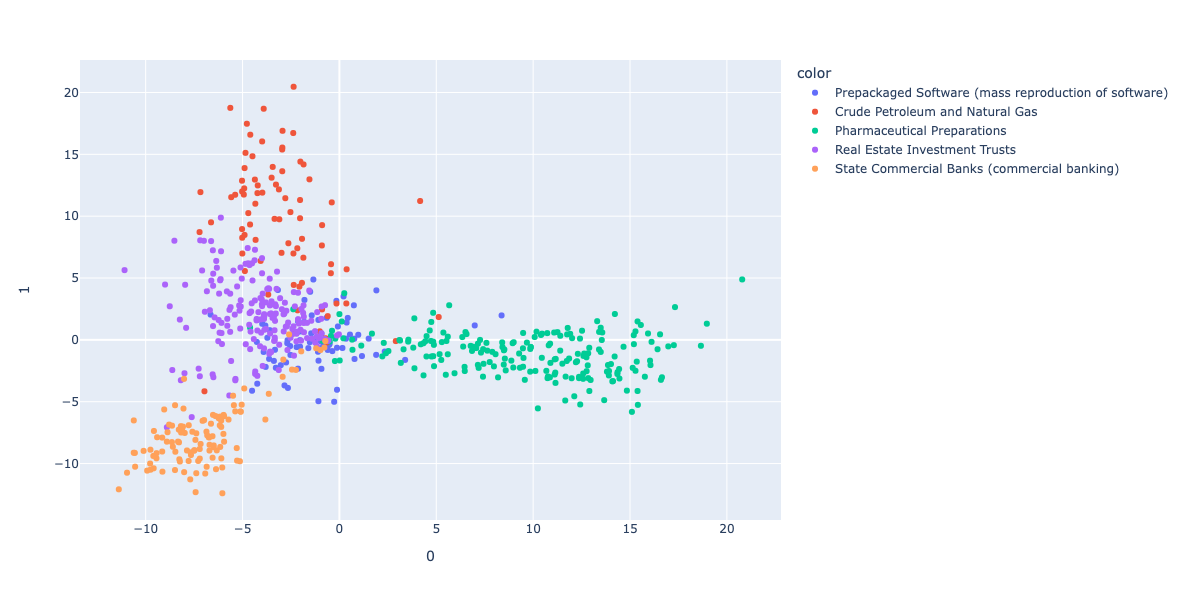

In [41]:
plot_pca_doc2vec = visualize_pca(doc_vec_2, df.loc[:,["name","SIC_desc"]])

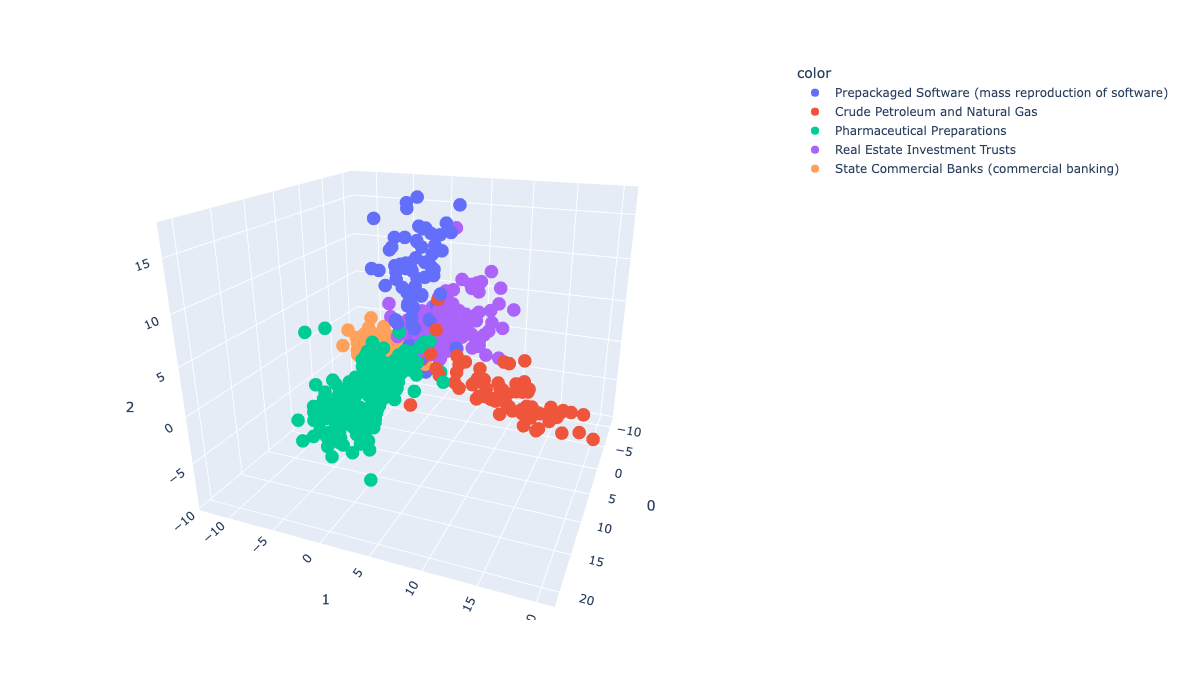

In [42]:
fig = px.scatter_3d(plot_pca_doc2vec[1], x =0 , y = 1, z = 2, hover_data={"name": plot_pca_doc2vec[1].index.get_level_values(0),
                                                              "industry": plot_pca_doc2vec[1].index.get_level_values(1)},
                    color = plot_pca_doc2vec[1].index.get_level_values(1), width=1200, height=700)
fig.show()

# confusion matrix/ accuracy measure?
perhaps use KNN and comapre to the cosine similarity work

collect all the work to get a good big picture idea of our progress